# Project 2 — Messier Observing Assistant

**Authors:** Abdirahman Abdullahi, Kyle Drees  
**Course:** Astronomy 1221  
**GitHub Repo:** https://github.com/MUTEJIMMY/Astr1221_Project2_Abdirahman

In this project, we build a small observing assistant for the Messier catalog:

- We load and clean a Messier catalog into a consistent table of all 110 objects.
- We add derived columns such as standardized coordinates, broad type categories,
  best viewing month, and season.
- We provide helper functions to:
  - filter objects by type, constellation, and magnitude,
  - summarize the catalog with tables and plots,
  - build observing plans by season, month, and equipment tier,
  - recommend Top 5 targets for a given location/month/gear setup,
  - plot sky maps and a dome view for those targets.
- We include an optional interactive block at the end that turns the notebook
  into a more complete observing tool using user input.

Run the notebook from top to bottom to reproduce the cleaned catalog, visualizations,
and observing tools.

## Project pathway and context

We followed **Pathway A — LLM-powered data-analysis project** using a large-language-model assistant
to help design and extend an observing companion for the **Messier Object Tourist Guide** project.

**Core concept:**  
We created an observing assistant that uses the Messier catalog (110 deep-sky objects) to
generate seasonal, brightness-based observing lists and sky charts, while also supporting
optional AI interaction for equipment-tier classification and user-input clarification.

**Data source:**  
Our final pipeline is based entirely on the provided **MessierObjects.xls** file, cleaned into a
consistent `messier` DataFrame with standardized columns (RA/Dec, Magnitude, Type, Constellation,
etc.). Earlier experiments with incomplete online catalogs (OpenNGC or web scraping) were
abandoned and marked as archive code.

**LLM integration:**  
We used AI tools (Cursor, ChatGPT, Anthropic SDK) to assist with code cleanup, function design,
and optional natural-language input classification (e.g., determining telescope tier from text).
The final workflow runs fully offline and does not require API access to reproduce results.

## Data sources

- `MessierObjects.xls`: base Messier catalog provided for the project.
- We clean this into `data/messier_clean.csv` for all later analysis.
- All plots, tables, and tools use this cleaned catalog.

## Imports and environment setup

This cell loads the Python libraries used in the project and installs two
dependencies:

- `xlrd` to read the `MessierObjects.xls` catalog.
- `geopy` for the optional interactive location-based observing assistant.

All later cells assume these imports have been run.

In [98]:
## Imports and setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from IPython.display import display

from astropy import units as u
from astropy.coordinates import SkyCoord

# Install helpers for reading Excel & geocoding (safe if already installed)
%pip install -q "xlrd>=2.0.1"
%pip install -q geopy

from geopy.geocoders import Nominatim

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q python-dotenv anthropic

from dotenv import load_dotenv
load_dotenv(override=True)  # <-- pick up the new value

import os
print("has_ANTHROPIC_API_KEY:", bool(os.getenv("ANTHROPIC_API_KEY")))

Note: you may need to restart the kernel to use updated packages.
has_ANTHROPIC_API_KEY: True


In [3]:
# From the project details it told me to download the messier objects, i just found someone's github repo that had then and then i double checked with claude if it was accuture, here im going to import then and then we can start.

# Attempt 1 (archive) — early data source (optional)

The cells below are from an earlier attempt using a different online catalog.
They are kept for reference but are **not** used in the final workflow.
The core, graded version of this project starts at:

`## NEW SOURCE: MessierObjects.xls Catalog`

You can skip directly to that section when reviewing.

//this is where i tried to import the messier files from a github boy was that a mistake but i wanted to document the journey
!git clone https://github.com/mattiaverga/OpenNGC.git


#Gave me an error so i fixed it by adding spe = ';'
ngc = pd.read_csv("OpenNGC/database_files/NGC.csv")
ngc.head()

In [4]:
ngc = pd.read_csv("OpenNGC/database_files/NGC.csv", sep=';')
ngc.head()

,Name,Type,RA,Dec,Const,MajAx,MinAx,PosAng,B-Mag,V-Mag,...,Cstar V-Mag,M,NGC,IC,Cstar Names,Identifiers,Common names,NED notes,OpenNGC notes,Sources
0,IC0001,**,00:08:27.05,+27:43:03.6,Peg,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Type:1|RA:1|Dec:1|Const:99
1,IC0002,G,00:11:00.88,-12:49:22.3,Cet,0.98,0.32,142.0,15.46,NaN,...,NaN,NaN,NaN,NaN,NaN,"2MASX J00110081-1249206,IRAS 00084-1306,MCG -0...",NaN,NaN,NaN,Type:1|RA:1|Dec:1|Const:99|MajAx:3|MinAx:3|Pos...
2,IC0003,G,00:12:06.09,-00:24:54.8,Psc,0.93,0.67,53.0,14.78,NaN,...,NaN,NaN,NaN,NaN,NaN,"2MASX J00120604-0024543,MCG +00-01-038,PGC 000...",NaN,NaN,NaN,Type:1|RA:1|Dec:1|Const:99|MajAx:3|MinAx:3|Pos...
3,IC0004,G,00:13:26.94,+17:29:11.2,Peg,1.17,0.84,12.0,14.14,NaN,...,NaN,NaN,NaN,NaN,NaN,"2MASX J00132695+1729111,IRAS 00108+1712,MCG +0...",NaN,NaN,NaN,Type:1|RA:1|Dec:1|Const:99|MajAx:3|MinAx:3|Pos...
4,IC0005,G,00:17:34.93,-09:32:36.1,Cet,0.99,0.66,9.0,14.57,NaN,...,NaN,NaN,NaN,NaN,NaN,"2MASX J00173495-0932364,MCG -02-01-047,PGC 001...",NaN,NaN,NaN,Type:1|RA:1|Dec:1|Const:99|MajAx:3|MinAx:3|Pos...


# Trying to fix NaN values
It seems like a lot of these values are NaN maybe it has something to do with the way I parsed the data, so I'll put some fixes in.

In [5]:
# keep rows that actually have coordinates
ngc = ngc.dropna(subset=['RA', 'Dec']).copy()

# fill number columns with each column's median
num_cols = ngc.select_dtypes(include='number').columns
ngc[num_cols] = ngc[num_cols].fillna(ngc[num_cols].median())

# fill text columns with "Unknown"
obj_cols = ngc.select_dtypes(include='object').columns
ngc[obj_cols] = ngc[obj_cols].fillna('Unknown')

# checking
print("shape (rows, cols):", ngc.shape)
print("missing RA:", ngc['RA'].isna().sum(), "| missing Dec:", ngc['Dec'].isna().sum())

# peek
ngc.head(3)

shape (rows, cols): (13962, 32)
missing RA: 0 | missing Dec: 0


,Name,Type,RA,Dec,Const,MajAx,MinAx,PosAng,B-Mag,V-Mag,...,Cstar V-Mag,M,NGC,IC,Cstar Names,Identifiers,Common names,NED notes,OpenNGC notes,Sources
0,IC0001,**,00:08:27.05,+27:43:03.6,Peg,1.20,0.69,87.0,14.42,12.38,...,15.145,56.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Type:1|RA:1|Dec:1|Const:99
1,IC0002,G,00:11:00.88,-12:49:22.3,Cet,0.98,0.32,142.0,15.46,12.38,...,15.145,56.0,Unknown,Unknown,Unknown,"2MASX J00110081-1249206,IRAS 00084-1306,MCG -0...",Unknown,Unknown,Unknown,Type:1|RA:1|Dec:1|Const:99|MajAx:3|MinAx:3|Pos...
2,IC0003,G,00:12:06.09,-00:24:54.8,Psc,0.93,0.67,53.0,14.78,12.38,...,15.145,56.0,Unknown,Unknown,Unknown,"2MASX J00120604-0024543,MCG +00-01-038,PGC 000...",Unknown,Unknown,Unknown,Type:1|RA:1|Dec:1|Const:99|MajAx:3|MinAx:3|Pos...


In [6]:
if 'ngc_raw' not in globals():
    ngc_raw = pd.read_csv("OpenNGC/database_files/NGC.csv", sep=';')  # from the OpenNGC folder

In [7]:
#this restarts from the raw copy so I don't carry the old median in M
ngc = ngc_raw.copy()

#this is to keep the rows that actually have the coordinates
ngc = ngc.dropna(subset=['RA', 'Dec'])

#this keeps id columns safe (dont fill with medians)
num_cols = ngc.select_dtypes(include='number').columns
num_cols = [c for c in num_cols if c not in ['M']]  # M is the Messier id, leave as NaN
ngc[num_cols] = ngc[num_cols].fillna(ngc[num_cols].median())

#fill text colummns
obj_cols = ngc.select_dtypes(include='object').columns
ngc[obj_cols] = ngc[obj_cols].fillna('Unknown')

#this marks which rows are messier objects
ngc['is_messier'] = ngc['M'].notna()

#this is a quick check
print("Total rows:", len(ngc))
print("Messier rows:", int(ngc['is_messier'].sum()))

#this shows a few messier rows
messier_preview = ngc[ngc['is_messier']][['Name','M','Type','RA','Dec']].head(5)
messier_preview

Total rows: 13962
Messier rows: 107


,Name,M,Type,RA,Dec
4903,IC4715,24.0,*Ass,18:16:56.12,-18:30:52.4
4913,IC4725,25.0,OCl,18:31:46.77,-19:06:53.8
5810,NGC0205,110.0,G,00:40:22.08,+41:41:07.1
5826,NGC0221,32.0,G,00:42:41.83,+40:51:55.0
5829,NGC0224,31.0,G,00:42:44.35,+41:16:08.6


In [8]:
# start with the numeric version of M
ngc.loc[:, 'M_num'] = pd.to_numeric(ngc['M'], errors='coerce')

# if M is blank, try to pull like "M45" or "M 045" from the Name text
from_name = ngc['Name'].str.extract(r'\bM\s*0*([0-9]{1,3})\b', expand=False)
ngc.loc[ngc['M_num'].isna(), 'M_num'] = pd.to_numeric(from_name, errors='coerce')

print("unique M numbers found so far:", int(ngc['M_num'].dropna().nunique()))

unique M numbers found so far: 107


In [9]:
#this creates the messier table if it isnt already in memory (prevents NameError)
if 'messier' not in globals():
    messier = ngc[ngc['is_messier']].copy()

# Missing Objects, there should be 110
SO now we have sorted these objects and have gotten the messier objects but we are missing 3 of them, which is annoying i will try and rectify that.

In [10]:
# this makes M_num (from 'M' or Name)
ngc.loc[:, 'M_num'] = pd.to_numeric(ngc['M'], errors='coerce')

# try to pull number from Name like "M45"
from_name = ngc['Name'].str.extract(r'\bM\s*0*([0-9]{1,3})\b', expand=False)
ngc.loc[ngc['M_num'].isna(), 'M_num'] = pd.to_numeric(from_name, errors='coerce')

# simple patches: M40, M45, M102
idx = ngc['Name'].str.contains(r'Winnecke|M\s*40', case=False, na=False)
ngc.loc[idx, 'M_num'] = 40

idx = ngc['Name'].str.contains(r'Pleiades|M\s*45', case=False, na=False)
ngc.loc[idx, 'M_num'] = 45

idx = (ngc['NGC'].astype(str) == '5866') | ngc['Name'].str.contains(r'NGC\s*5866', case=False, na=False)
ngc.loc[idx, 'M_num'] = 102

# make the messier table and count
messier = ngc[ngc['M_num'].between(1, 110, inclusive='both')].dropna(subset=['M_num']).copy()
messier['M_num'] = messier['M_num'].astype(int)
messier = messier.sort_values('M_num')

present  = sorted(messier['M_num'].unique().tolist())
expected = list(range(1, 111))
missing  = [m for m in expected if m not in present]

print("unique M we have:", len(present))
print("missing M numbers:", missing)

unique M we have: 108
missing M numbers: [40, 45]


In [11]:
#this looks for M40 / M45 tags or aliases across ALL text columns
txt_cols = ngc.select_dtypes(include='object').columns
_show = [c for c in ['Name','M','Identifiers','Common names'] if c in ngc.columns]

def any_contains(pattern):
    return pd.DataFrame({c: ngc[c].str.contains(pattern, case=False, na=False) for c in txt_cols}).any(axis=1)

m40_tag   = any_contains(r'\bM\s*0*40\b')
m45_tag   = any_contains(r'\bM\s*0*45\b')
winnecke  = any_contains(r'Winnecke|WNC\s*4|ADS\s*9299')          # common M40 names
pleiades  = any_contains(r'Pleiades|Seven\s*Sisters|Melotte\s*22|Mel\s*22|Collinder\s*42|Cr\s*42')  # M45 names

print("M40 tagged:", int(m40_tag.sum()), "  winnecke:", int(winnecke.sum()))
display(ngc.loc[m40_tag | winnecke, _show].head(12))

print("\nM45 tagged:", int(m45_tag.sum()), "  pleiades:", int(pleiades.sum()))
display(ngc.loc[m45_tag | pleiades, _show].head(12))

M40 tagged: 0   winnecke: 0


,Name,M,Identifiers,Common names



M45 tagged: 0   pleiades: 0


,Name,M,Identifiers,Common names


# NEW SOURCE: MessierObjects.xls Catalog

The earlier approach (using the OpenNGC-style table) was missing some Messier
entries and felt fragile. From this point on I switch to one clean, local
source: the `MessierObjects.xls` catalog (included in this repo). In the next
cells I load that file, standardize the columns, and build a verified table of
all 110 Messier objects that the rest of this notebook uses.

## Build local Messier catalog

This cell reads the `MessierObjects.xls` file (included in the repo) and saves a
clean copy as `data/messier_raw.csv`. That cached file is what later cells use
so the notebook can be run without redownloading anything.

In [69]:
# build data/messier_raw.csv once from the Excel
DATA = Path("data"); DATA.mkdir(exist_ok=True)
raw_path = DATA / "messier_raw.csv"

if not raw_path.exists():
    xls = Path("MessierObjects.xls")
    if not xls.exists():
        xls = Path.home() / "Downloads" / "MessierObjects.xls"
    assert xls.exists(), "Put 'MessierObjects.xls' here or in ~/Downloads"

    df_raw = pd.read_excel(xls, engine="xlrd", header=1).dropna(axis=1, how="all")
    df_raw.to_csv(raw_path, index=False)
    print("saved raw:", raw_path)
else:
    print("using raw cache:", raw_path)

using raw cache: data/messier_raw.csv


## Inspect processed Messier catalog

Here I load the cached `messier_raw.csv` file (generated from `MessierObjects.xls`
in the previous cell) and display the first few rows to confirm it looks correct.

In [70]:
messier = pd.read_csv("data/messier_raw.csv")
messier.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,ObjectNum,Name,Type,Constellation,RAHour,RAMinute,DecSign,DecDeg,DecMinute,Magnitude,Info,Distance (ly)
1,1,NGC 1952 Crab Nebula,Supernova Remnant,Taurus,5,34.5,+,22,1,8.4,Size: 6.0x4.0,6300
2,2,NGC 7089,Globular Cluster,Aquarius,21,33.5,-,0,49,6.5,Size: 12.9,37500
3,3,NGC 5272,Globular Cluster,Canes Venatici,13,42.2,+,28,23,6.2,Size: 16.2,33900
4,4,NGC 6121,Globular Cluster,Scorpius,16,23.6,-,26,32,5.6,Size: 26.3,7200


## Clean and standardize Messier catalog

This cell turns the raw Messier table into a robust catalog:

1. Fix a misplaced header row if needed.
2. Normalize the Messier ID column to `M`.
3. Convert RA/Dec pieces into `RA_deg` and `Dec_deg`.
4. Coerce numeric columns (e.g., `Magnitude`).
5. Keep only core columns needed for this project.
6. Verify that all 110 Messier objects (M1–M110) are present.

In [71]:
# Clean table and compute RA/Dec (works with either raw parts or ready-made columns)

m = messier.copy()

# 1) Promote header row if it slipped into row 0
hdr = m.iloc[0].astype(str).str.strip()
if not any(c in m.columns for c in ("ObjectNum", "ObjctNum", "M", "Messier")) \
   and any(x in hdr.values  for x in ("ObjectNum", "ObjctNum", "M", "Messier")):
    m.columns = hdr
    m = m.iloc[1:].reset_index(drop=True)

# 2) Normalize Messier ID -> "M"
if   "ObjectNum" in m.columns: id_col = "ObjectNum"
elif "ObjctNum"  in m.columns: id_col = "ObjctNum"
elif "M"         in m.columns: id_col = "M"
elif "Messier"   in m.columns: id_col = "Messier"
else:
    raise ValueError(f"Cannot find Messier ID column; got {list(m.columns)}")
m.rename(columns={id_col: "M"}, inplace=True)

# 3) Coerce numeric where present
for c in ["M", "RAHour", "RAMinute", "DecDeg", "DecMinute", "Magnitude", "RA_deg", "Dec_deg"]:
    if c in m.columns:
        m[c] = pd.to_numeric(m[c], errors="coerce")

# 4) RA in degrees
if {"RAHour", "RAMinute"}.issubset(m.columns):
    m["RA_deg"] = 15.0 * (m["RAHour"].fillna(0) + m["RAMinute"].fillna(0) / 60.0)
elif "RA_deg" in m.columns:
    pass
else:
    raise ValueError("No RA columns found (need RAHour/RAMinute or RA_deg).")

# 5) Dec in degrees
if {"DecDeg", "DecMinute"}.issubset(m.columns):
    sign_col = m.get("DecSign")
    sign = np.where(sign_col.astype(str).str.strip().eq("-"), -1, 1) if sign_col is not None else 1
    m["Dec_deg"] = sign * (m["DecDeg"].fillna(0) + m["DecMinute"].fillna(0) / 60.0)
elif "Dec_deg" in m.columns:
    pass
else:
    raise ValueError("No Dec columns found (need DecSign/DecDeg/DecMinute or Dec_deg).")

# 6) Keep core columns
cols = ["M", "Name", "Type", "Constellation", "RA_deg", "Dec_deg", "Magnitude"]
cols = [c for c in cols if c in m.columns]
messier_clean = m[cols].sort_values("M").reset_index(drop=True)

# 7) Sanity: exactly 1..110 present
assert set(messier_clean["M"].dropna().astype(int)) == set(range(1, 111))

# 8) Save clean catalog and set working table
out_path = Path("data") / "messier_clean.csv"
messier_clean.to_csv(out_path, index=False)

messier = messier_clean.copy()

print("rows:", len(messier_clean))
messier_clean.head()

rows: 110


,M,Name,Type,Constellation,RA_deg,Dec_deg,Magnitude
0,1,NGC 1952 Crab Nebula,Supernova Remnant,Taurus,83.625,22.016667,8.4
1,2,NGC 7089,Globular Cluster,Aquarius,323.375,-0.816667,6.5
2,3,NGC 5272,Globular Cluster,Canes Venatici,205.550,28.383333,6.2
3,4,NGC 6121,Globular Cluster,Scorpius,245.900,-26.533333,5.6
4,5,NGC 5904,Globular Cluster,Serpens Caput,229.650,2.083333,5.6


## Verify saved clean catalog

Reload `data/messier_clean.csv` to confirm it was written correctly and set
`messier` for the rest of the notebook (no re-saving here to avoid redundancy).

In [72]:
# Sanity check: reload the clean catalog


messier = pd.read_csv("data/messier_clean.csv")
print(f"rows: {len(messier)}")
messier.head()

rows: 110


,M,Name,Type,Constellation,RA_deg,Dec_deg,Magnitude
0,1,NGC 1952 Crab Nebula,Supernova Remnant,Taurus,83.625,22.016667,8.4
1,2,NGC 7089,Globular Cluster,Aquarius,323.375,-0.816667,6.5
2,3,NGC 5272,Globular Cluster,Canes Venatici,205.550,28.383333,6.2
3,4,NGC 6121,Globular Cluster,Scorpius,245.900,-26.533333,5.6
4,5,NGC 5904,Globular Cluster,Serpens Caput,229.650,2.083333,5.6


# Finally done with all the hard annoying sorting of the data

## Sky map of all Messier objects

Now that the catalog is cleaned, this plot shows all Messier objects on the sky
Right Ascension is flipped so that the chart matches standard star chart
orientation (east to the left), and marker size roughly encodes brightness
(brighter objects = larger points).

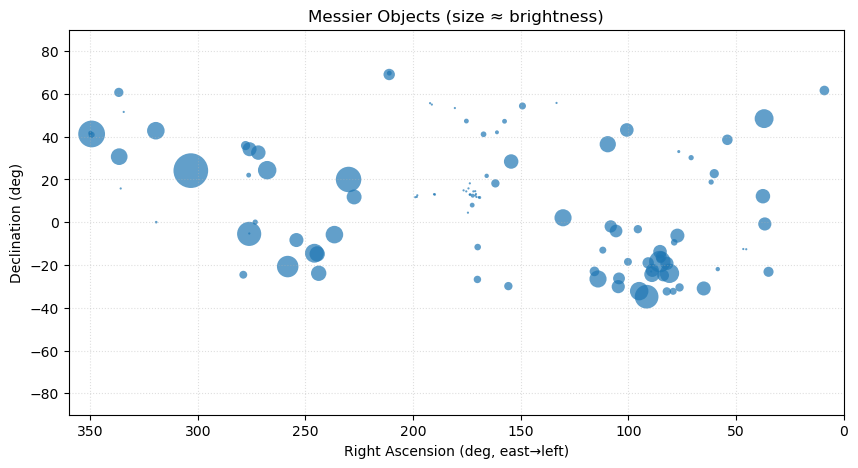

In [73]:
# Quick sky map: RA vs Dec (larger marker ≈ brighter object)
m = messier.dropna(subset=["RA_deg", "Dec_deg", "Magnitude"]).copy()

# Flip RA so the sky reads east→left like printed star charts
x = 360 - m["RA_deg"]
y = m["Dec_deg"]

# Size scale: brighter (smaller magnitude) -> larger marker
sizes = (9.5 - m["Magnitude"]).clip(lower=0.5) ** 2 * 10

plt.figure(figsize=(10, 5))
plt.scatter(x, y, s=sizes, alpha=0.7, edgecolors="none")
plt.xlim(360, 0)
plt.ylim(-90, 90)
plt.xlabel("Right Ascension (deg, east→left)")
plt.ylabel("Declination (deg)")
plt.title("Messier Objects (size ≈ brightness)")
plt.grid(True, linestyle=":", alpha=0.4)
plt.show()

## Messier objects by type

This section summarizes how many Messier objects fall into each type
(cluster, nebula, galaxy, etc.) and visualizes the counts in a horizontal bar chart.

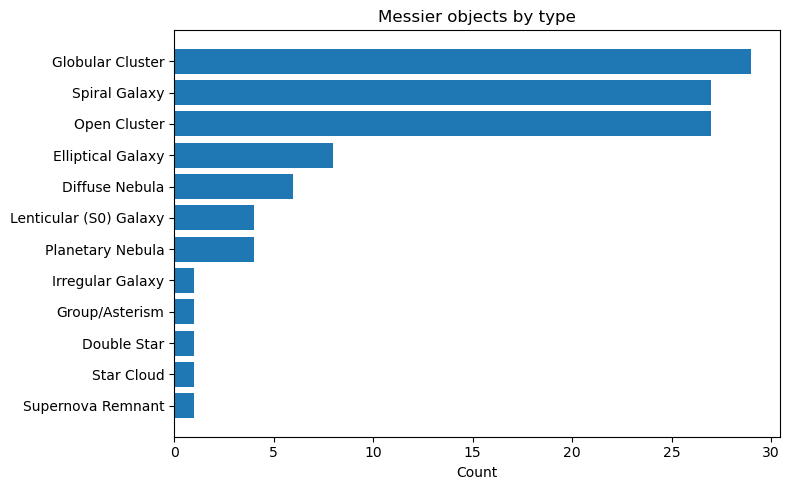

In [74]:
# Breakdown by object type (table + bar chart)
type_counts = (
    messier["Type"]
    .value_counts()
    .sort_values(ascending=True)
)

# Show as table
type_counts.to_frame("count")

# Show as bar chart
plt.figure(figsize=(8, 5))
plt.barh(type_counts.index.to_list(), type_counts.values)
plt.xlabel("Count")
plt.title("Messier objects by type")
plt.tight_layout()
plt.show()

## Finder table: brightest Messier objects

This cell builds a compact finder table sorted by brightness. It adds human-readable
RA/Dec strings (if missing) using `astropy.coordinates.SkyCoord`, then keeps key
columns (name, type, constellation, position, magnitude) for quick observing use.

In [75]:
# Build a compact finder table (sorted by brightest first)

# Ensure RA/Dec string columns exist
if not {"RA_hms", "Dec_dms"}.issubset(messier.columns):
    c = SkyCoord(
        ra=messier["RA_deg"].values * u.deg,
        dec=messier["Dec_deg"].values * u.deg,
        frame="icrs"
    )
    messier["RA_hms"] = c.ra.to_string(
        unit=u.hour, sep=":", precision=2, pad=True
    )
    messier["Dec_dms"] = c.dec.to_string(
        unit=u.deg, sep=":", precision=1, pad=True, alwayssign=True
    )

cols_wanted = [
    "M", "Name", "Type", "Constellation", "Magnitude",
    "RA_hms", "Dec_dms", "RA_deg", "Dec_deg"
]
cols = [c for c in cols_wanted if c in messier.columns]

finder = (
    messier[cols]
    .dropna(subset=["Magnitude"])   # need magnitude to sort
    .sort_values("Magnitude")       # smaller mag = brighter
    .reset_index(drop=True)
)

print("rows:", len(finder))
finder.head(20)

rows: 109


,M,Name,Type,Constellation,Magnitude,RA_hms,Dec_dms,RA_deg,Dec_deg
0,45,"Pleiades, Subaru, Seven Sisters",Open Cluster,Taurus,1.6,03:47:00.00,+24:07:12.0,56.750,24.120000
1,31,NGC 224 Andromeda Galaxy,Spiral Galaxy,Andromeda,3.4,00:42:42.00,+41:16:00.0,10.675,41.266667
2,44,NGC 2632 Beehive Cluster (Praesepe),Open Cluster,Cancer,3.7,08:40:06.00,+19:59:00.0,130.025,19.983333
3,42,NGC 1976 Great Orion Nebula,Diffuse Nebula,Orion,4.0,05:35:24.00,-05:27:00.0,83.850,-5.450000
4,7,NGC 6475 Ptolemy¹s Cluster,Open Cluster,Scorpius,4.1,17:53:54.00,-34:49:00.0,268.475,-34.816667
5,41,NGC 2287,Open Cluster,Canis Major,4.6,06:47:00.00,-20:44:00.0,101.750,-20.733333
6,24,NGC 6603 Milky Way Patch,Star Cloud,Sagittarius,4.6,18:18:24.00,-18:25:00.0,274.600,-18.416667
7,22,NGC 6656,Globular Cluster,Sagittarius,5.1,18:36:24.00,-23:54:00.0,279.100,-23.900000
8,47,NGC 2422,Open Cluster,Puppis,5.2,07:36:36.00,-14:30:00.0,114.150,-14.500000
9,39,NGC 7092,Open Cluster,Cygnus,5.2,21:32:12.00,+48:26:00.0,323.050,48.433333


## Helper: quick finder function

This helper function lets a user filter the finder table by object type,
constellation, and maximum magnitude. It returns a small table of matching
Messier objects (brightest first) for quick observing planning.

In [76]:
# Quick finder: filter by type / constellation / magnitude
def find(obj_type=None, mag=None, const=None, n=20, cols=None):
    """
    Filter the Messier finder table.

    Parameters
    ----------
    obj_type : str or None
        Substring to match in the Type column (e.g., "open", "globular", "galaxy").
    mag : float or None
        Maximum magnitude (keep objects this bright or brighter).
    const : str or None
        Substring to match in the Constellation name (e.g., "Scorpi", "Androm").
    n : int
        Maximum number of rows to return.
    cols : list or None
        Columns to include in the result (defaults to a standard subset).

    Returns
    -------
    pandas.DataFrame
        Filtered view of bright Messier targets.
    """
    df = finder.copy()

    if obj_type:
        df = df[df["Type"].str.contains(obj_type, case=False, na=False)]
    if const:
        df = df[df["Constellation"].str.contains(const, case=False, na=False)]
    if mag is not None:
        df = df[df["Magnitude"] <= float(mag)]

    df = df.sort_values(["Magnitude", "M"]).reset_index(drop=True)

    if cols is None:
        cols = ["M", "Name", "Type", "Constellation", "Magnitude", "RA_hms", "Dec_dms"]

    return df[cols].head(n)

# Example uses (for the reader)
find(obj_type="open", mag=6.5)
find(const="Scorpi", mag=6)
find(obj_type="galaxy", mag=9, n=15)

,M,Name,Type,Constellation,Magnitude,RA_hms,Dec_dms
0,31,NGC 224 Andromeda Galaxy,Spiral Galaxy,Andromeda,3.4,00:42:42.00,+41:16:00.0
1,33,NGC 598 Triangulum/Pinwheel Galaxy,Spiral Galaxy,Triangulum,5.7,01:33:54.00,+30:39:00.0
2,81,NGC 3031 Bode¹s Galaxy,Spiral Galaxy,Ursa Major,6.9,09:55:36.00,+69:04:00.0
3,83,NGC 5236 Southern Pinwheel Galaxy,Spiral Galaxy,Hydra,7.6,13:37:00.00,-29:52:00.0
4,101,NGC 5457 Pinwheel Galaxy,Spiral Galaxy,Ursa Major,7.9,14:03:12.00,+54:21:00.0
5,104,NGC 4594 Sombrero Galaxy,Spiral Galaxy,Virgo,8.0,12:40:00.00,-11:37:00.0
6,32,NGC 221 Satellite of M31,Elliptical Galaxy,Andromeda,8.1,00:42:42.00,+40:52:00.0
7,94,NGC 4736,Spiral Galaxy,Canes Venatici,8.2,12:50:54.00,+41:07:00.0
8,49,NGC 4472,Elliptical Galaxy,Virgo,8.4,12:29:48.00,+08:00:00.0
9,51,NGC 5194 Whirlpool Galaxy,Spiral Galaxy,Canes Venatici,8.4,13:29:54.00,+47:12:00.0


## Magnitude distribution of Messier objects

Here I summarize how bright the Messier objects are overall. The printout shows
basic statistics (min/median/max), and the histogram shows how many targets fall
into each magnitude range.

n = 109 | min = 1.6 | max = 10.2 | median = 7.6


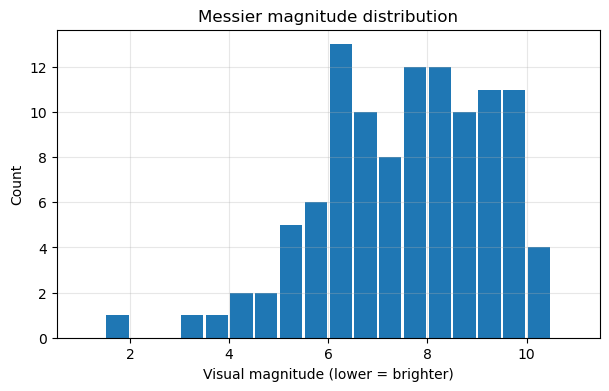

In [77]:
# Magnitude histogram + quick stats
mags = messier["Magnitude"].dropna()

print(
    "n =", len(mags),
    "| min =", mags.min(),
    "| max =", mags.max(),
    "| median =", mags.median()
)

plt.figure(figsize=(7, 4))
bins = np.arange(np.floor(mags.min()), np.ceil(mags.max()) + 0.5, 0.5)
plt.hist(mags, bins=bins, rwidth=0.9)
plt.xlabel("Visual magnitude (lower = brighter)")
plt.ylabel("Count")
plt.title("Messier magnitude distribution")
plt.grid(True, alpha=0.3)
plt.show()

## Bucket detailed types into broad categories

To simplify later visualizations, this step groups the original `Type` labels
into four broad categories: Galaxy, Nebula, Cluster, and Other. This makes it
easier to see high-level trends in the Messier catalog.

In [78]:
# bucket Type into 3 big groups and make it a categorical column

def _bucket_type(t):
    s = "" if pd.isna(t) else str(t).strip().lower()
    if "galaxy" in s:
        return "Galaxy"
    if "nebula" in s or "remnant" in s:
        return "Nebula"
    if "cluster" in s or "asterism" in s or "star cloud" in s:
        return "Cluster"
    return "Other"

messier["TypeCat"] = messier["Type"].map(_bucket_type)
messier["TypeCat"] = pd.Categorical(
    messier["TypeCat"],
    categories=["Galaxy", "Nebula", "Cluster", "Other"],
    ordered=True,
)

# quick sanity
print(messier["TypeCat"].value_counts().to_string())
messier[["M", "Name", "Type", "TypeCat"]].head(10)

TypeCat
Cluster    58
Galaxy     40
Nebula     11
Other       1


,M,Name,Type,TypeCat
0,1,NGC 1952 Crab Nebula,Supernova Remnant,Nebula
1,2,NGC 7089,Globular Cluster,Cluster
2,3,NGC 5272,Globular Cluster,Cluster
3,4,NGC 6121,Globular Cluster,Cluster
4,5,NGC 5904,Globular Cluster,Cluster
5,6,NGC 6405 Butterfly Cluster,Open Cluster,Cluster
6,7,NGC 6475 Ptolemy¹s Cluster,Open Cluster,Cluster
7,8,NGC 6523 Lagoon Nebula,Diffuse Nebula,Nebula
8,9,NGC 6333,Globular Cluster,Cluster
9,10,NGC 6254,Globular Cluster,Cluster


## Estimate best viewing month and season

Using each object's RA, this step estimates the best month to observe it near
local midnight from the northern hemisphere. I map RA to the nearest "midnight"
RA for each month, then convert that into a rough observing season (Winter,
Spring, Summer, Fall). This creates `BestMonth` and `Season` columns that power
later summaries.

In [79]:
# add BestMonth and Season from RA (northern hemisphere)

# RA in hours
ra_h = (messier["RA_deg"] / 15.0) % 24

# month centers at local midnight (Sun_RA + 12h):
# Jan..Dec  → [8, 10, 12, 14, 16, 18, 20, 22, 0, 2, 4, 6] hours
month_centers = np.array([8, 10, 12, 14, 16, 18, 20, 22, 0, 2, 4, 6], dtype=float)
month_names   = np.array(
    ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
)

# choose the nearest month center on a circle (0–24h wrap)
# circular distance trick: ((x - c + 12) % 24) - 12  → in [-12, +12]
diff = ((ra_h.values[:, None] - month_centers[None, :] + 12) % 24) - 12
best_idx = np.argmin(np.abs(diff), axis=1)

messier["BestMonth"] = month_names[best_idx]

# simple seasons (northern hemisphere)
season_map = {
    "Dec": "Winter", "Jan": "Winter", "Feb": "Winter",
    "Mar": "Spring", "Apr": "Spring", "May": "Spring",
    "Jun": "Summer", "Jul": "Summer", "Aug": "Summer",
    "Sep": "Fall",   "Oct": "Fall",   "Nov": "Fall",
}
messier["Season"] = messier["BestMonth"].map(season_map)

# quick peek
print(messier["Season"].value_counts().to_string())
messier[["M","Name","RA_deg","BestMonth","Season","TypeCat"]].head(12)

Season
Spring    41
Summer    36
Winter    22
Fall      11


,M,Name,RA_deg,BestMonth,Season,TypeCat
0,1,NGC 1952 Crab Nebula,83.625,Dec,Winter,Nebula
1,2,NGC 7089,323.375,Aug,Summer,Cluster
2,3,NGC 5272,205.550,Apr,Spring,Cluster
3,4,NGC 6121,245.900,May,Spring,Cluster
4,5,NGC 5904,229.650,May,Spring,Cluster
5,6,NGC 6405 Butterfly Cluster,265.025,Jun,Summer,Cluster
6,7,NGC 6475 Ptolemy¹s Cluster,268.475,Jun,Summer,Cluster
7,8,NGC 6523 Lagoon Nebula,270.950,Jun,Summer,Nebula
8,9,NGC 6333,259.800,Jun,Summer,Cluster
9,10,NGC 6254,254.275,May,Spring,Cluster


## Helper: get objects by season or month

This function lets a user pull a customized list of Messier objects by season
or best month, with optional filters on brightness and broad type category.
It's the main "observer-facing" query built on the cleaned catalog.

In [80]:
# Get objects by season or by month, with optional brightness/type filters
def get_by_season(season=None, month=None, max_mag=None, typecat=None, n=20, cols=None):
    """
    Return a filtered list of Messier objects by season/month and basic criteria.

    Requires that the notebook has already created the BestMonth and Season
    columns from RA (see the 'Estimate best viewing month and season' cell).

    Parameters
    ----------
    season : str or None
        "winter", "spring", "summer", or "fall"/"autumn" (case-insensitive).
    month : str or None
        Full or 3-letter month name (e.g., "September" or "Sep").
    max_mag : float or None
        Maximum visual magnitude (keeps objects this bright or brighter).
    typecat : str or None
        Broad type category: "Galaxy", "Nebula", or "Cluster" (case-insensitive).
    n : int
        Maximum number of rows to return.
    cols : list or None
        Subset of columns to include in the result.

    Returns
    -------
    pandas.DataFrame
        Filtered table of Messier objects sorted by brightness.
    """
    df = messier.copy()

    # Ensure required columns exist
    for col in ["BestMonth", "Season"]:
        if col not in df.columns:
            raise ValueError(
                f"Column '{col}' not found. Run the cell that creates BestMonth/Season before using get_by_season()."
            )

    # Season filter
    if season is not None:
        s = str(season).strip().lower()
        s = {"autumn": "fall"}.get(s, s)
        s = s.capitalize()  # "Spring", "Fall", etc.
        df = df[df["Season"] == s]

    # Month filter
    if month is not None:
        m = str(month).strip().lower()[:3]
        month_map = {
            "jan": "Jan", "feb": "Feb", "mar": "Mar", "apr": "Apr",
            "may": "May", "jun": "Jun", "jul": "Jul", "aug": "Aug",
            "sep": "Sep", "oct": "Oct", "nov": "Nov", "dec": "Dec"
        }
        if m not in month_map:
            raise ValueError("month must be a real month like 'Sep' or 'September'")
        df = df[df["BestMonth"] == month_map[m]]

    # Brightness filter
    if max_mag is not None:
        df = df[df["Magnitude"] <= float(max_mag)]

    # Broad type category filter
    if typecat is not None:
        t = str(typecat).strip().lower().capitalize()  # "Galaxy", "Nebula", "Cluster"
        df = df[df["TypeCat"] == t]

    # Columns to show
    if cols is None:
        cols = [
            "M", "Name", "TypeCat", "Type", "Constellation",
            "Magnitude", "RA_hms", "Dec_dms", "BestMonth", "Season"
        ]

    out = (
        df.sort_values("Magnitude", na_position="last")[cols]
        .reset_index(drop=True)
    )

    return out.head(n)

In [82]:
# Example: bright spring galaxies
get_by_season(season="spring", max_mag=9, typecat="galaxy", n=10)

,M,Name,TypeCat,Type,Constellation,Magnitude,RA_hms,Dec_dms,BestMonth,Season
0,83,NGC 5236 Southern Pinwheel Galaxy,Galaxy,Spiral Galaxy,Hydra,7.6,13:37:00.00,-29:52:00.0,Apr,Spring
1,101,NGC 5457 Pinwheel Galaxy,Galaxy,Spiral Galaxy,Ursa Major,7.9,14:03:12.00,+54:21:00.0,Apr,Spring
2,104,NGC 4594 Sombrero Galaxy,Galaxy,Spiral Galaxy,Virgo,8.0,12:40:00.00,-11:37:00.0,Mar,Spring
3,94,NGC 4736,Galaxy,Spiral Galaxy,Canes Venatici,8.2,12:50:54.00,+41:07:00.0,Mar,Spring
4,49,NGC 4472,Galaxy,Elliptical Galaxy,Virgo,8.4,12:29:48.00,+08:00:00.0,Mar,Spring
5,51,NGC 5194 Whirlpool Galaxy,Galaxy,Spiral Galaxy,Canes Venatici,8.4,13:29:54.00,+47:12:00.0,Apr,Spring
6,106,NGC 4258,Galaxy,Spiral Galaxy,Canes Venatici,8.4,12:19:00.00,+47:18:00.0,Mar,Spring
7,64,NGC 4826 Blackeye Galaxy,Galaxy,Spiral Galaxy,Coma Berenices,8.5,12:56:42.00,+21:41:00.0,Mar,Spring
8,63,NGC 5055 Sunflower Galaxy,Galaxy,Spiral Galaxy,Canes Venatici,8.6,13:15:48.00,+42:02:00.0,Apr,Spring
9,87,NGC 4486 Virgo A,Galaxy,Elliptical Galaxy,Virgo,8.6,12:30:48.00,+12:24:00.0,Mar,Spring


## Observing plans by gear, season, and month

Using the `get_by_season` helper, this section builds quick target lists based
on simple equipment tiers (binoculars vs small/medium/big telescope). The user
chooses a season or month and a tier, and the functions return Messier objects
that should be reachable.

In [84]:
# Simple equipment tiers: approximate max visual magnitude
equipment_tiers = {
    "binoculars":   {"max_mag": 6.5},   # 7x50 / 10x50 under decent skies
    "small_scope":  {"max_mag": 8.0},   # ~80–100 mm
    "medium_scope": {"max_mag": 9.0},   # ~130–200 mm
    "big_scope":    {"max_mag": 10.0},  # 250 mm+
}

def plan_by_season(season, tier="small_scope", typecat=None, n=20, cols=None):
    """
    Return a brightness-limited list of Messier objects for a season,
    based on a chosen equipment tier.
    """
    if tier not in equipment_tiers:
        raise ValueError(f"Unknown tier '{tier}'. Use one of: {list(equipment_tiers.keys())}")
    max_mag = equipment_tiers[tier]["max_mag"]
    return get_by_season(season=season, max_mag=max_mag, typecat=typecat, n=n, cols=cols)

def plan_by_month(month, tier="small_scope", typecat=None, n=20, cols=None):
    """
    Same idea as plan_by_season, but filtered by best month instead of season.
    """
    if tier not in equipment_tiers:
        raise ValueError(f"Unknown tier '{tier}'. Use one of: {list(equipment_tiers.keys())}")
    max_mag = equipment_tiers[tier]["max_mag"]
    return get_by_season(month=month, max_mag=max_mag, typecat=typecat, n=n, cols=cols)

# Example observing plans
display(plan_by_season("spring", tier="big_scope", typecat="galaxy", n=12))
display(plan_by_month("Oct", tier="medium_scope", typecat="cluster", n=15))

,M,Name,TypeCat,Type,Constellation,Magnitude,RA_hms,Dec_dms,BestMonth,Season
0,83,NGC 5236 Southern Pinwheel Galaxy,Galaxy,Spiral Galaxy,Hydra,7.6,13:37:00.00,-29:52:00.0,Apr,Spring
1,101,NGC 5457 Pinwheel Galaxy,Galaxy,Spiral Galaxy,Ursa Major,7.9,14:03:12.00,+54:21:00.0,Apr,Spring
2,104,NGC 4594 Sombrero Galaxy,Galaxy,Spiral Galaxy,Virgo,8.0,12:40:00.00,-11:37:00.0,Mar,Spring
3,94,NGC 4736,Galaxy,Spiral Galaxy,Canes Venatici,8.2,12:50:54.00,+41:07:00.0,Mar,Spring
4,49,NGC 4472,Galaxy,Elliptical Galaxy,Virgo,8.4,12:29:48.00,+08:00:00.0,Mar,Spring
5,51,NGC 5194 Whirlpool Galaxy,Galaxy,Spiral Galaxy,Canes Venatici,8.4,13:29:54.00,+47:12:00.0,Apr,Spring
6,106,NGC 4258,Galaxy,Spiral Galaxy,Canes Venatici,8.4,12:19:00.00,+47:18:00.0,Mar,Spring
7,64,NGC 4826 Blackeye Galaxy,Galaxy,Spiral Galaxy,Coma Berenices,8.5,12:56:42.00,+21:41:00.0,Mar,Spring
8,63,NGC 5055 Sunflower Galaxy,Galaxy,Spiral Galaxy,Canes Venatici,8.6,13:15:48.00,+42:02:00.0,Apr,Spring
9,87,NGC 4486 Virgo A,Galaxy,Elliptical Galaxy,Virgo,8.6,12:30:48.00,+12:24:00.0,Mar,Spring


,M,Name,TypeCat,Type,Constellation,Magnitude,RA_hms,Dec_dms,BestMonth,Season
0,34,NGC 1039,Cluster,Open Cluster,Perseus,5.5,02:42:00.00,+42:47:00.0,Oct,Fall
1,103,NGC 581,Cluster,Open Cluster,Cassiopeia,7.4,01:33:12.00,+60:42:00.0,Oct,Fall


## Export observing plans to CSV

This helper lets a user take any filtered observing plan (e.g., from
`plan_by_season` or `plan_by_month`) and save it as a CSV file in the `data/`
folder so it can be used outside the notebook.

In [85]:
# Export a plan DataFrame to CSV
def export_plan(df, filename="plan.csv", folder="data"):
    Path(folder).mkdir(exist_ok=True)
    out_path = Path(folder) / filename
    df.to_csv(out_path, index=False)
    print("saved:", out_path)
    return out_path

# Example: make a plan and save it
spring_galaxies_small = plan_by_season(
    "spring", tier="small_scope", typecat="galaxy", n=15
)
export_plan(spring_galaxies_small, "spring_galaxies_small_scope.csv")
spring_galaxies_small.head()

saved: data/spring_galaxies_small_scope.csv


,M,Name,TypeCat,Type,Constellation,Magnitude,RA_hms,Dec_dms,BestMonth,Season
0,83,NGC 5236 Southern Pinwheel Galaxy,Galaxy,Spiral Galaxy,Hydra,7.6,13:37:00.00,-29:52:00.0,Apr,Spring
1,101,NGC 5457 Pinwheel Galaxy,Galaxy,Spiral Galaxy,Ursa Major,7.9,14:03:12.00,+54:21:00.0,Apr,Spring
2,104,NGC 4594 Sombrero Galaxy,Galaxy,Spiral Galaxy,Virgo,8.0,12:40:00.00,-11:37:00.0,Mar,Spring


## Sky chart for an observing plan

This helper takes any plan table (e.g., from `plan_by_season`) and plots the
targets on an RA/Dec sky chart. RA is flipped so east is on the left (like real
star charts), and marker size scales with brightness.

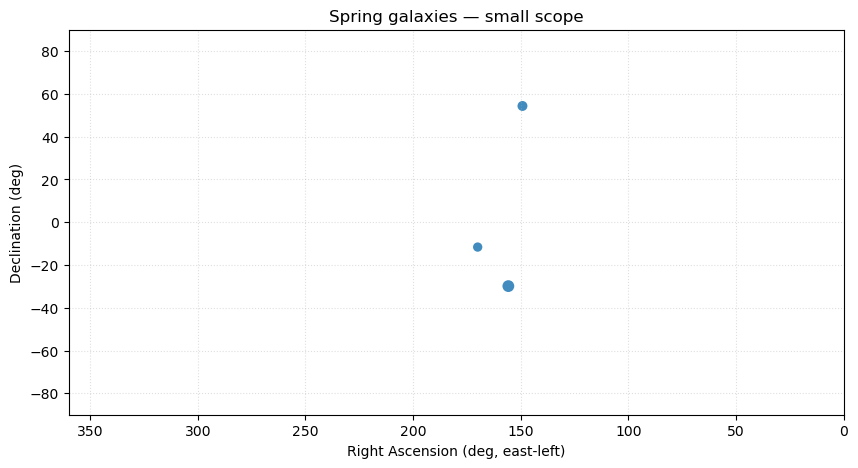

In [88]:
# Sky chart for a plan (east-left like a star chart)
def plot_plan(df, title=None, annotate=False):
    """
    Plot an observing plan on an RA/Dec sky chart.

    Parameters
    ----------
    df : pandas.DataFrame
        Plan DataFrame with an M column.
    title : str or None
        Optional plot title.
    annotate : bool
        If True, label points with object names.
    """
    # Keep unique Messier IDs from the plan
    plan_ids = df[["M"]].drop_duplicates()

    # Join with master table to get RA/Dec/Magnitude/Name/TypeCat
    base = messier[["M", "RA_deg", "Dec_deg", "Magnitude", "Name", "TypeCat"]]
    merged = plan_ids.merge(base, on="M", how="left")

    # Flip RA so east is on the left
    x = 360 - merged["RA_deg"]
    y = merged["Dec_deg"]

    # Bigger dot = brighter (fallback mag if missing)
    mags = merged["Magnitude"].fillna(9.9)
    sizes = (9.5 - mags).clip(lower=0.5) ** 2 * 20

    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, s=sizes, alpha=0.85, edgecolors="none")

    if annotate:
        for xx, yy, name in zip(x, y, merged["Name"]):
            plt.text(xx, yy, str(name), fontsize=8, ha="left", va="bottom")

    plt.xlim(360, 0)
    plt.ylim(-90, 90)
    plt.xlabel("Right Ascension (deg, east-left)")
    plt.ylabel("Declination (deg)")
    plt.title(title or "Observing plan")
    plt.grid(True, linestyle=":", alpha=0.4)
    plt.show()

# Example (you can uncomment for the grader)
#plot_plan(spring_galaxies_small, title="Spring galaxies — small scope", annotate=False)

## Extra query helpers and object stories

These helpers provide quick ways to:
- filter by detailed or broad type and magnitude,
- pull objects within a magnitude range, and
- generate a short "story" for a specific Messier object using the table fields.
They sit on top of the cleaned `messier` catalog and make the tool more user-friendly.

In [89]:
# Filter by broad type category or substring in the detailed Type
def filter_by_type(typecat=None, type_contains=None, max_mag=None, n=20, cols=None):
    """
    Filter Messier objects by broad type (TypeCat), substring in Type, and max magnitude.
    """
    df = messier.copy()

    # Broad category match: "galaxy", "nebula", "cluster", "other"
    if typecat:
        t = str(typecat).strip().lower()
        df = df[df["TypeCat"].str.lower() == t]

    # Detailed type substring: e.g. "spiral", "open", "globular"
    if type_contains:
        df = df[df["Type"].str.contains(str(type_contains), case=False, na=False)]

    # Brightness cap
    if max_mag is not None:
        df = df[df["Magnitude"].notna() & (df["Magnitude"] <= float(max_mag))]

    if cols is None:
        cols = [
            "M", "Name", "TypeCat", "Type", "Constellation", "Magnitude",
            "RA_hms", "Dec_dms", "BestMonth", "Season"
        ]
    cols = [c for c in cols if c in df.columns]

    return (
        df.sort_values("Magnitude", na_position="last")[cols]
        .reset_index(drop=True)
        .head(int(n))
    )


# Filter by magnitude range only
def find_by_magnitude(max_mag, min_mag=None, n=20, cols=None):
    """
    Return Messier objects within a magnitude range, brightest first.
    """
    df = messier[messier["Magnitude"].notna()].copy()
    df = df[df["Magnitude"] <= float(max_mag)]
    if min_mag is not None:
        df = df[df["Magnitude"] >= float(min_mag)]

    if cols is None:
        cols = [
            "M", "Name", "TypeCat", "Type", "Constellation", "Magnitude",
            "RA_hms", "Dec_dms", "BestMonth", "Season"
        ]
    cols = [c for c in cols if c in df.columns]

    return (
        df.sort_values("Magnitude", na_position="last")[cols]
        .reset_index(drop=True)
        .head(int(n))
    )


# Tiny "story" snippets for a few showcase objects
_object_snippets = {
    31: "andromeda galaxy; bright core + faint disk in binoculars.",
    42: "orion nebula; look for the trapezium stars.",
    45: "pleiades; easy in city skies, blue haze in dark skies.",
    51: "whirlpool; spiral arms possible on steady, dark nights.",
    13: "m13 hercules cluster; resolves into tons of stars.",
}

def get_object_story(m):
    """
    Return a short description for a given Messier object ID.
    """
    m = int(m)
    row = messier.loc[messier["M"] == m]
    if row.empty:
        return f"M{m}: not in table."

    r = row.iloc[0]
    mag_txt = (
        f"{r['Magnitude']:.1f}"
        if ("Magnitude" in r and pd.notna(r["Magnitude"]))
        else "—"
    )
    base = (
        f"M{m}: {str(r.get('Name','')).strip()} — "
        f"{str(r.get('Type','')).lower()} in {r.get('Constellation','')}.\n"
        f"mag ~{mag_txt}; best month {r.get('BestMonth','?')}. "
        f"RA {r.get('RA_hms','?')}, Dec {r.get('Dec_dms','?')}."
    )
    tip = _object_snippets.get(m)
    return base if tip is None else base + "\n" + tip

## Quick demo of query helpers

This cell provides a light sanity check that the helper functions work as
intended, without flooding the notebook with too many tables.

In [90]:
# quick demo (uncomment if i want a table sample)
# display(filter_by_type(typecat="galaxy", max_mag=7, n=8))
# display(find_by_magnitude(max_mag=6.5, n=10))

#print(get_object_story(31))  # andromeda sanity check

## Advanced: rank best targets for a given location, month, and gear

This section builds a simple scoring model to answer:
"Given my latitude, gear, and month, what are the best Messier targets?"
It uses:
- an approximate RA↔month mapping,
- max altitude at transit,
- a brightness limit from the equipment tier,
- and a combined score (brightness + altitude + in-season match).

In [92]:
# Month → rough RA (hours) on the meridian at midnight
_MONTH_TO_RA_H = {
    "jan": 6,  "feb": 8,  "mar": 10, "apr": 12,
    "may": 14, "jun": 16, "jul": 18, "aug": 20,
    "sep": 22, "oct": 0,  "nov": 2,  "dec": 4,
}

def _midnight_ra_for_month(month):
    """Approximate RA on the meridian at local midnight for a given month."""
    m = str(month).strip().lower()[:3]
    if m not in _MONTH_TO_RA_H:
        raise ValueError("month should be like 'Oct' or 'October'")
    return float(_MONTH_TO_RA_H[m])

def _max_altitude_deg(lat_deg, dec_deg):
    """Max altitude at transit: 90 - |lat - dec| (vectorized for dec_deg)."""
    return 90.0 - abs(lat_deg - dec_deg)

def _month_gap(obj_ra_h, month_ra_h):
    """
    How far the object's RA is from the month's midnight RA,
    expressed in ~months (0 to about 6).
    """
    ha = abs(((obj_ra_h - month_ra_h + 12) % 24) - 12)  # 0..12 hours
    return ha / 2.0  # ~months

def _apply_tier(df, tier, fallback_max=9.5):
    """Filter by gear brightness limit using equipment_tiers from above."""
    max_mag = equipment_tiers.get(tier, {}).get("max_mag", fallback_max)
    return df[df["Magnitude"].fillna(99) <= max_mag].copy()

def rank_visible_topN(lat_deg,
                      month,
                      tier="small_scope",
                      typecat=None,
                      min_alt=25.0,
                      n=5):
    """
    Rank the best Messier targets for a given latitude, month, and gear.

    Parameters
    ----------
    lat_deg : float
        Observer latitude in degrees (north positive).
    month : str
        Month name, full or 3-letter (e.g., "March" or "Mar").
    tier : str
        Equipment tier key from equipment_tiers.
    typecat : str or None
        Optional broad type filter: "Galaxy", "Nebula", "Cluster", etc.
    min_alt : float
        Minimum acceptable max altitude in degrees.
    n : int
        Number of top targets to return.

    Returns
    -------
    pandas.DataFrame
        Top-N ranked targets with a Score column.
    """
    month_ra = _midnight_ra_for_month(month)

    df = messier.copy()

    # Optional type category filter
    if typecat:
        t = str(typecat).strip().capitalize()
        df = df[df["TypeCat"] == t]

    # Gear brightness limit
    df = _apply_tier(df, tier)
    if df.empty:
        return df

    # Features for scoring
    ra_h = df["RA_deg"] / 15.0
    alt_max = _max_altitude_deg(lat_deg, df["Dec_deg"])
    gap_mo = _month_gap(ra_h, month_ra)

    # Attach features
    df = df.assign(AltMax_deg=alt_max, MonthGap=gap_mo)

    # Drop targets that never get high enough
    df = df[df["AltMax_deg"] >= min_alt].copy()
    if df.empty:
        return df

    # Score = brightness (b) + altitude (a) + in-season match (m)
    b = np.clip((10.0 - df["Magnitude"]) / 10.0, 0, 1)                  # brighter better
    a = np.clip((df["AltMax_deg"] - min_alt) / (90.0 - min_alt), 0, 1)  # higher better
    m = np.clip(1.0 - df["MonthGap"] / 6.0, 0, 1)                       # closer in-season better

    score = 0.5 * b + 0.35 * a + 0.15 * m

    df = df.assign(Score=score).sort_values(
        ["Score", "Magnitude"], ascending=[False, True]
    )

    cols = [
        "M", "Name", "TypeCat", "Type", "Constellation", "Magnitude",
        "RA_hms", "Dec_dms", "BestMonth", "Season",
        "AltMax_deg", "MonthGap", "Score"
    ]
    cols = [c for c in cols if c in df.columns]

    return df[cols].reset_index(drop=True).head(n)

## Quick Test

In [93]:
rank_visible_topN(lat_deg=40.0, month="March", tier="small_scope", typecat="Galaxy", n=5)

,M,Name,TypeCat,Type,Constellation,Magnitude,RA_hms,Dec_dms,BestMonth,Season,AltMax_deg,MonthGap,Score
0,31,NGC 224 Andromeda Galaxy,Galaxy,Spiral Galaxy,Andromeda,3.4,00:42:42.00,+41:16:00.0,Sep,Fall,88.733333,4.644167,0.707075
1,33,NGC 598 Triangulum/Pinwheel Galaxy,Galaxy,Spiral Galaxy,Triangulum,5.7,01:33:54.00,+30:39:00.0,Oct,Fall,80.650000,4.217500,0.559216
2,81,NGC 3031 Bode¹s Galaxy,Galaxy,Spiral Galaxy,Ursa Major,6.9,09:55:36.00,+69:04:00.0,Feb,Winter,60.933333,0.036667,0.497571
3,101,NGC 5457 Pinwheel Galaxy,Galaxy,Spiral Galaxy,Ursa Major,7.9,14:03:12.00,+54:21:00.0,Apr,Spring,75.650000,2.026667,0.477064
4,104,NGC 4594 Sombrero Galaxy,Galaxy,Spiral Galaxy,Virgo,8.0,12:40:00.00,-11:37:00.0,Mar,Spring,38.383333,1.333333,0.288731


## Top 5 recommendation helper

This function wraps the ranking logic into a single user-facing tool:
given a latitude, month, gear tier, and optional type filter, it:
1) shows the top 5 Messier targets,
2) plots them on a sky chart, and
3) can optionally export the plan to CSV.

In [95]:
# Top 5 helper (main user-facing shortcut)
def suggest_top5(lat_deg: float,
                 month: str,
                 tier: str = "small_scope",
                 typecat: str | None = None,
                 title: str | None = None,
                 export_csv: bool = False):
    """
    Show the top 5 Messier targets for a given location, month, and gear tier.

    - Uses rank_visible_topN(...) for scoring.
    - Displays a table of the top 5.
    - Plots them on a sky chart (with labels).
    - Optionally exports the plan as a CSV file.
    """
    # Validate tier
    if tier not in equipment_tiers:
        raise ValueError(f"Unknown tier '{tier}'. Use one of: {list(equipment_tiers.keys())}")

    top5 = rank_visible_topN(
        lat_deg=lat_deg,
        month=month,
        tier=tier,
        typecat=typecat,
        n=5
    )

    if top5.empty:
        print("No objects with these settings. Try a brighter tier or a different month.")
        return top5

    display(top5)

    # Default title if none provided
    if title is None:
        tcat_label = typecat if typecat else "all types"
        title = (
            f"Top 5 for {month.title()} @ lat {lat_deg:.1f}°, "
            f"tier {tier} ({tcat_label})"
        )

    # Plot plan; ignore plotting errors so table still works
    try:
        plot_plan(top5, title=title, annotate=True)
    except Exception:
        pass

    # Optional CSV export
    if export_csv:
        fn = f"plan_top5_{month.lower()}_{tier}.csv".replace(" ", "_")
        export_plan(top5, fn)

    return top5

## How to run the Top 5 tool

Examples:

- Columbus (~40°N), October, small scope:
  ```python
  suggest_top5(40.0, "Oct", tier="small_scope")

,M,Name,TypeCat,Type,Constellation,Magnitude,RA_hms,Dec_dms,BestMonth,Season,AltMax_deg,MonthGap,Score
0,31,NGC 224 Andromeda Galaxy,Galaxy,Spiral Galaxy,Andromeda,3.4,00:42:42.00,+41:16:00.0,Sep,Fall,88.733333,0.355833,0.814284
1,45,"Pleiades, Subaru, Seven Sisters",Cluster,Open Cluster,Taurus,1.6,03:47:00.00,+24:07:12.0,Nov,Fall,74.120000,1.891667,0.787201
2,34,NGC 1039,Cluster,Open Cluster,Perseus,5.5,02:42:00.00,+42:47:00.0,Oct,Fall,87.216667,1.350000,0.676263
3,39,NGC 7092,Cluster,Open Cluster,Cygnus,5.2,21:32:12.00,+48:26:00.0,Aug,Summer,81.566667,1.231667,0.663798
4,33,NGC 598 Triangulum/Pinwheel Galaxy,Galaxy,Spiral Galaxy,Triangulum,5.7,01:33:54.00,+30:39:00.0,Oct,Fall,80.650000,0.782500,0.645091


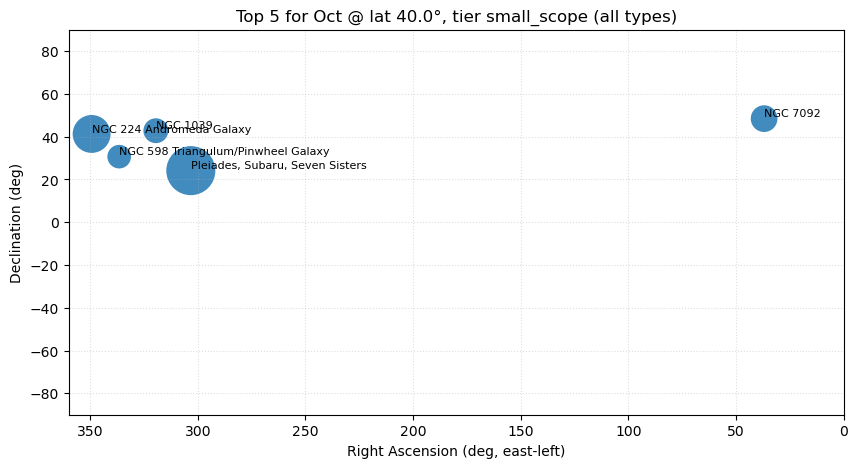

In [96]:
# Configuration "knobs"
LAT = 40.0              # observer latitude (e.g., Columbus ~40°N)
MONTH = "Oct"           # full or 3-letter month name
TIER = "small_scope"    # binoculars | small_scope | medium_scope | big_scope
TYPECAT = None          # None = all types; or "galaxy" / "cluster" / "nebula" / "cluster"
EXPORT = False          # True = save CSV plan into data/

# Run the tool
top5 = suggest_top5(LAT, MONTH, tier=TIER, typecat=TYPECAT, export_csv=EXPORT)


The `!pip install` command will install the xlrd package in your environment. After that, the pandas read_excel function should work correctly with your .xls file.

## Advanced interactive tool: city, gear, sky maps, and "freedom units"

This (optional) section turns the notebook into a full observing assistant:

- Takes a **city** from the user and geocodes it (via `geopy`) to get latitude/longitude.
- Asks for a **month** and a description of your **observing gear**.
  - Optionally uses an LLM (if configured) plus a heuristic to choose an equipment tier
    (`small_scope`, `medium_scope`, `big_scope`).
- Uses the earlier `rank_visible_topN` logic to build a **Top 5 Messier plan** tailored to:
  - your location,
  - your month,
  - your gear,
  - and an optional type filter (galaxy / nebula / cluster).
- Adds a **best local hour** estimate for each target using `astropy` and local night-time sampling.
- Plots:
  - a **flat RA/Dec chart** for the Top 5 (east-left, color-coded),
  - a **dome (polar) sky view** at local midnight for that location/month.
- For the brightest recommended object, computes a fun **distance breakdown** in:
  - lightyears,
  - football fields,
  - McChickens,
  - AU,
  - and city blocks (“freedom units” visualization).

This block is an extra interactive/demo mode built on top of the cleaned `messier` catalog
and earlier helper functions. It shows how
the tool can be extended into a more complete observing assistant.

city (e.g., 'Columbus, OH' or 'Nairobi, Kenya'):  Columbus Ohio
month (ex: Oct; blank = current):  Oct
What are you using? (naked eye / binoculars / telescope + size, e.g., '8 inch Dob'):  eye


tier selected: small_scope


type [galaxy / nebula / cluster] (blank = all):  



city: Columbus, Ohio, United States of America  |  lat ~ 39.96°  |  month: Oct  |  tier: small_scope  |  type: all


,M,Name,TypeCat,Type,Constellation,Magnitude,RA_hms,Dec_dms,BestMonth,Season,AltMax_deg,MonthGap,Score,BestHour (local)
0,31,NGC 224 Andromeda Galaxy,Galaxy,Spiral Galaxy,Andromeda,3.4,00:42:42.00,+41:16:00.0,Sep,Fall,88.695593,0.355833,0.814080,23:00
1,45,"Pleiades, Subaru, Seven Sisters",Cluster,Open Cluster,Taurus,1.6,03:47:00.00,+24:07:12.0,Nov,Fall,74.157740,1.891667,0.787404,23:00
2,34,NGC 1039,Cluster,Open Cluster,Perseus,5.5,02:42:00.00,+42:47:00.0,Oct,Fall,87.178927,1.350000,0.676060,01:00
3,39,NGC 7092,Cluster,Open Cluster,Cygnus,5.2,21:32:12.00,+48:26:00.0,Aug,Summer,81.528927,1.231667,0.663595,19:00
4,33,NGC 598 Triangulum/Pinwheel Galaxy,Galaxy,Spiral Galaxy,Triangulum,5.7,01:33:54.00,+30:39:00.0,Oct,Fall,80.687740,0.782500,0.645295,02:00


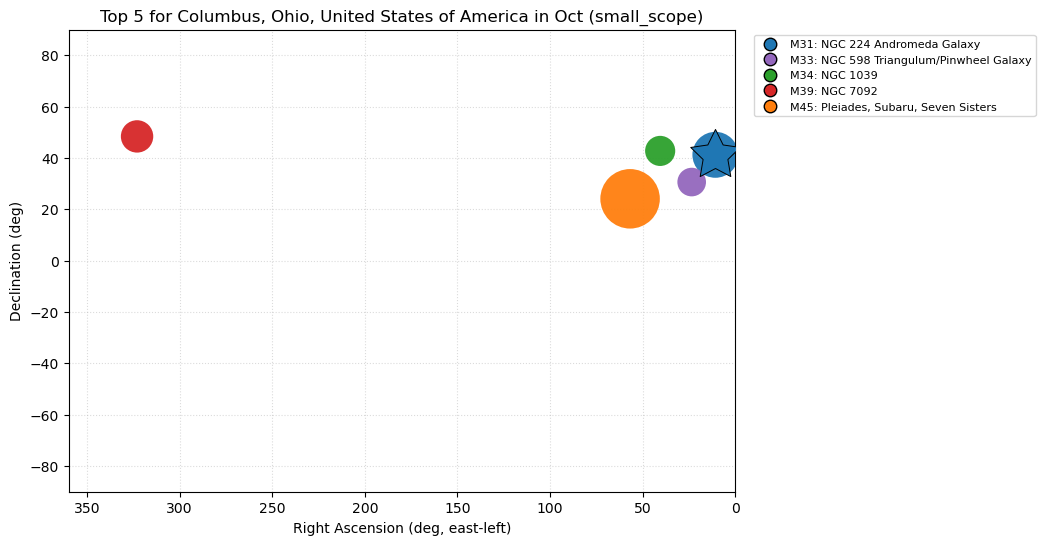

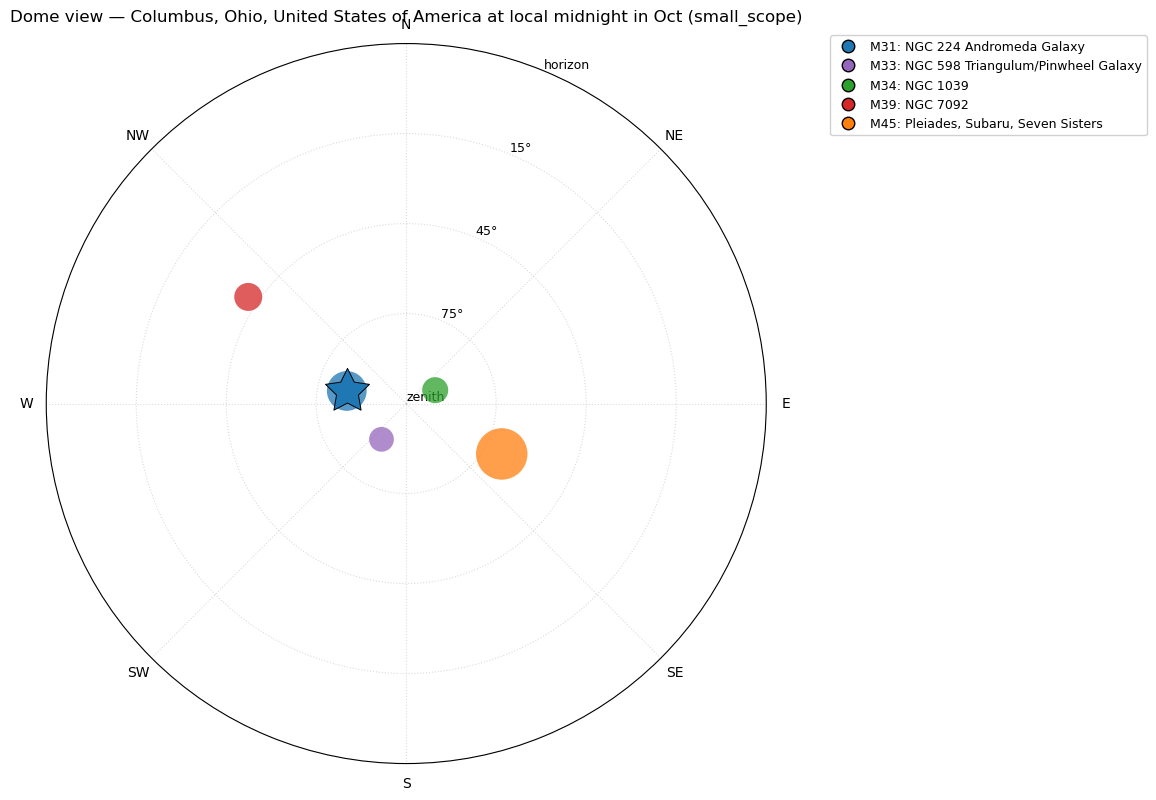

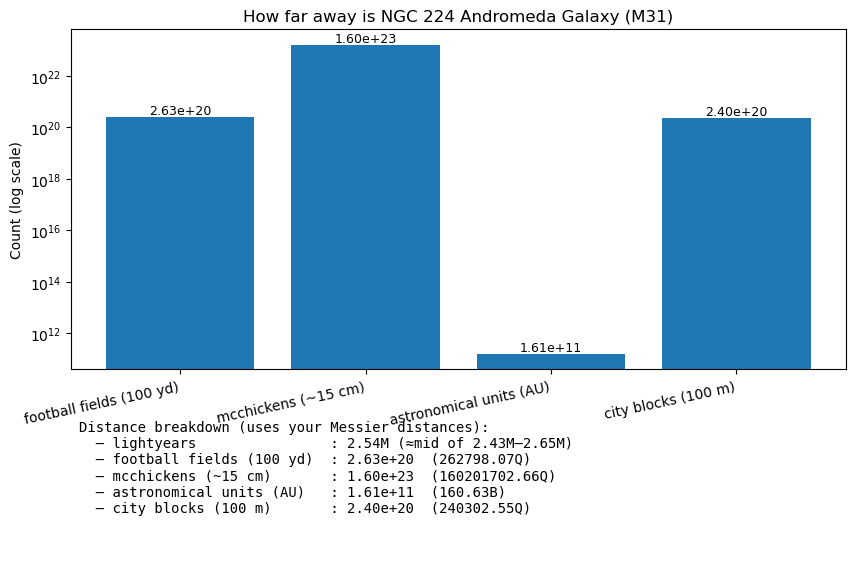

In [99]:
# City → lat/lon with simple clarification (state/province) only when needed,
# then build Top 5, flat RA/Dec chart (colored, star for best) + dome view (midnight, horizon filter).
# Distances: uses your Messier light-year data (single values or ranges). Freedom-units uses those.

from datetime import datetime, timedelta
import os, re, json
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
import matplotlib.gridspec as gridspec

# --- month helpers ---
_month3 = {
    "jan":"Jan","feb":"Feb","mar":"Mar","apr":"Apr","may":"May","jun":"Jun",
    "jul":"Jul","aug":"Aug","sep":"Sep","oct":"Oct","nov":"Nov","dec":"Dec"
}
_mon_num = {"Jan":1,"Feb":2,"Mar":3,"Apr":4,"May":5,"Jun":6,
            "Jul":7,"Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12}

def _utc_offset_hours(lon_deg: float) -> int:
    return int(round(lon_deg / 15.0))

def _midnight_utc(lon_deg: float, month_str: str) -> Time:
    m3 = month_str[:3].title()
    mon = _mon_num.get(m3, datetime.now().month)
    yr  = datetime.now().year
    dt_local = datetime(yr, mon, 15, 0, 0, 0)  # local midnight on the 15th
    return Time(dt_local - timedelta(hours=_utc_offset_hours(lon_deg)))

def _night_grid_utc(lon_deg: float, month_str: str):
    m3 = month_str[:3].title()
    mon = _mon_num.get(m3, datetime.now().month)
    yr  = datetime.now().year
    local_hours = list(range(18, 24)) + list(range(0, 7))
    ts = []
    for h in local_hours:
        day = 15 if h >= 18 else 16
        dt_local = datetime(yr, mon, day, h, 0, 0)
        ts.append(dt_local - timedelta(hours=_utc_offset_hours(lon_deg)))
    return Time(ts), local_hours

# --- (optional) Anthropic for gear tier ---
try:
    from anthropic import Anthropic
    _anth = Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))
    _models = [m.id for m in _anth.models.list().data]
    _anth_model = (
        "claude-3-5-sonnet-latest"
        if "claude-3-5-sonnet-latest" in _models
        else ("claude-3-5-haiku-latest" if "claude-3-5-haiku-latest" in _models else (_models[0] if _models else None))
    )
except Exception:
    _anth, _anth_model = None, None

def _ask_llm_for_tier(gear_text: str) -> str | None:
    if not (_anth and _anth_model): return None
    prompt = (
        "Classify the user's observing gear into one tier.\n"
        "Allowed tiers: small_scope, medium_scope, big_scope.\n"
        "- Naked-eye/binoculars -> small_scope.\n"
        "- Telescopes: <120 mm small; 120–200 mm medium; ≥250 mm big.\n"
        "- If unclear, choose small_scope.\n"
        'Return ONLY JSON like {"tier":"medium_scope"}.\n'
        f"Gear: {gear_text!r}"
    )
    try:
        msg = _anth.messages.create(model=_anth_model, max_tokens=60, messages=[{"role":"user","content":prompt}])
        txt = msg.content[0].text.strip()
        m = re.search(r'"tier"\s*:\s*"(small_scope|medium_scope|big_scope)"', txt, re.I)
        return m.group(1) if m else None
    except Exception:
        return None

# --- geocoder & city resolve ---
_geocode = Nominatim(user_agent="messier_student", timeout=10)
_alias = {"la":"Los Angeles, CA, USA", "l.a.":"Los Angeles, CA, USA", "nyc":"New York City, NY, USA"}

def _label_from_addr(raw):
    a = (raw or {}).get("address", {})
    city = a.get("city") or a.get("town") or a.get("village") or a.get("hamlet") or a.get("state_district") or raw.get("name")
    region = a.get("state") or a.get("region") or a.get("province") or a.get("state_district") or ""
    country = a.get("country","")
    return ", ".join([x for x in [city, region, country] if x]), (raw.get("type") or "").lower(), city or "", region or "", country or ""

def geocode_candidates(q: str, limit: int = 12, allow_counties: bool = False):
    try: L = _geocode.geocode(q, exactly_one=False, limit=limit, addressdetails=True)
    except Exception: L = None
    out, seen = [], set()
    if L:
        for loc in L:
            raw = loc.raw or {}
            label, kind, city, region, country = _label_from_addr(raw)
            if not label or label in seen: continue
            seen.add(label)
            is_county = ("county" in kind) or (("county" in (raw.get("display_name","").lower())) and not city)
            if is_county and not allow_counties: continue
            imp = float(raw.get("importance", 0.0))
            out.append({"label":label,"lat":float(loc.latitude),"lon":float(loc.longitude),
                        "importance":imp,"kind":kind,"city":city,"region":region,"country":country})
    def _rank(c):
        bonus = 0
        if "state" in c["kind"]: bonus += 3
        if any(k in c["kind"] for k in ("city","town","village","capital")): bonus += 2
        if "county" in c["kind"]: bonus -= 2
        return (bonus, c["importance"])
    out.sort(key=_rank, reverse=True)
    return out

def resolve_city_interactive(start_text: str, max_rounds: int = 4):
    q = (start_text or "").strip()
    if q.lower() in _alias: q = _alias[q.lower()]
    rounds = 0
    while rounds < max_rounds:
        rounds += 1
        if not q or len(q) < 2:
            q = input("City (e.g., 'Springfield, IL' or 'Nairobi, Kenya'): ").strip(); continue
        cands = geocode_candidates(q, allow_counties=("county" in q.lower()))
        if not cands:
            print(f"No matches for '{q}'.")
            q = input("Try 'City, State/Province' or 'City, Country' (or 'q' to quit): ").strip()
            if q.lower() in {"q","quit","exit"}: raise SystemExit("Aborted: city not resolved.")
            continue
        if len(cands) == 1:
            c = cands[0]; return (c["lat"], c["lon"]), c["label"]
        base_city = q.split(",")[0].strip()
        region_hint = input(f"Which state/province (or country) for '{base_city}'? (or 'q' to quit): ").strip()
        if region_hint.lower() in {"q","quit","exit"}: raise SystemExit("Aborted: city not resolved.")
        if not region_hint:
            q = input("Retype as 'City, State/Province' or 'City, Country': ").strip(); continue
        rh = region_hint.lower()
        narrowed = [c for c in cands if rh in c["region"].lower() or rh in c["country"].lower()]
        if narrowed:
            narrowed.sort(key=lambda c: any(k in c["kind"] for k in ("city","town","village")), reverse=True)
            c = narrowed[0]; return (c["lat"], c["lon"]), c["label"]
        else:
            q = f"{base_city}, {region_hint}"
    raise SystemExit("Aborted: city not resolved after several tries.")

# --- tier heuristics ---
def _heuristic_tier(gear_text: str) -> str:
    s = (gear_text or "").lower()
    if any(w in s for w in ["naked","unaided","bare eye","bare eyes"]): return "small_scope"
    if "binocular" in s: return "small_scope"
    mm = None
    m_mm = re.search(r'(\d+(?:\.\d+)?)\s*mm', s)
    m_in = re.search(r'(\d+(?:\.\d+)?)\s*(?:in|inch|inches|")', s)
    if m_mm: mm = float(m_mm.group(1))
    elif m_in: mm = float(m_in.group(1)) * 25.4
    if mm is not None:
        if mm < 120: return "small_scope"
        if mm < 200: return "medium_scope"
        if mm >= 250: return "big_scope"
        return "medium_scope"
    if any(w in s for w in ["telescope","dob","newtonian","refractor","sct"]): return "medium_scope"
    return "small_scope"

def choose_tier_from_gear() -> str:
    gear = input("What are you using? (naked eye / binoculars / telescope + size, e.g., '8 inch Dob'): ").strip()
    tier = _ask_llm_for_tier(gear) or _heuristic_tier(gear)
    print(f"tier selected: {tier}")
    return tier

# ---- inputs ----
city_raw = input("city (e.g., 'Columbus, OH' or 'Nairobi, Kenya'): ").strip()
(lat_deg, lon_deg), city_label = resolve_city_interactive(city_raw)
month_in = input("month (ex: Oct; blank = current): ").strip()
month = _month3.get(month_in.lower()[:3], datetime.now().strftime("%b")) if month_in else datetime.now().strftime("%b")
tier = choose_tier_from_gear()
type_txt = input("type [galaxy / nebula / cluster] (blank = all): ").strip()
typecat = type_txt.capitalize() if type_txt else None

# ---- Top 5 (your function) ----
top5 = rank_visible_topN(lat_deg=lat_deg, month=month, tier=tier, typecat=typecat, n=5)

# ---- add BestHour(local), preserve columns ----
def add_best_hour_local(plan_df, lat_deg: float, lon_deg: float, month_hint: str):
    if plan_df is None or len(plan_df) == 0: return plan_df
    base = messier[["M","RA_deg","Dec_deg","Magnitude","Name"]]
    merged = base.merge(plan_df, on="M", how="inner", suffixes=("", "_plan"))
    loc = EarthLocation(lat=lat_deg*u.deg, lon=lon_deg*u.deg)
    times_utc, local_hours = _night_grid_utc(lon_deg, month_hint)
    best_hours = []
    for _, row in merged.iterrows():
        sc = SkyCoord(ra=row["RA_deg"]*u.deg, dec=row["Dec_deg"]*u.deg, frame="icrs")
        alt = sc.transform_to(AltAz(obstime=times_utc, location=loc)).alt.deg
        best_hours.append("-" if not np.any(alt > 0) else f"{local_hours[int(np.argmax(alt))]:02d}:00")
    out = plan_df.copy().reset_index(drop=True)
    out["BestHour (local)"] = best_hours
    return out

top5 = add_best_hour_local(top5, lat_deg, lon_deg, month)

print(f"\ncity: {city_label or 'unknown'}  |  lat ~ {lat_deg:.2f}°  |  month: {month}  |  tier: {tier}  |  type: {typecat or 'all'}")
try:
    display(top5)
except Exception:
    print(top5)

# ========================  SHARED COLORS & BEST-ID  ========================
cmap = plt.get_cmap("tab10")
row_colors = [cmap(i) for i in range(min(5, len(top5)))]
M_to_color = {int(top5.iloc[i]["M"]): row_colors[i] for i in range(len(top5))}
best_M = int(top5.iloc[0]["M"]) if len(top5) else None

# ========================  FLAT RA/Dec CHART (colored; no extra second plot)  ========================
def plot_plan_colored(plan_df, title):
    base = messier[["M","RA_deg","Dec_deg","Magnitude","Name"]]
    merged = base.merge(plan_df[["M","Name","Magnitude"]], on="M", how="inner", suffixes=("", "_top5"))
    # magnitude from base (fallback safe)
    mag = (merged["Magnitude"]
           if "Magnitude" in merged.columns
           else merged.filter(regex=r"^Magnitude").iloc[:,0]).values
    sizes = np.clip(9.5 - mag, 0.5, None)**2 * 28

    fig, ax = plt.subplots(figsize=(8.6, 6.0))
    # draw each point with row color; best uses a true star
    for i, row in merged.iterrows():
        mnum = int(row["M"]); col = M_to_color.get(mnum, "C0")
        ax.scatter(row["RA_deg"], row["Dec_deg"], s=sizes[i]*1.05, color=col,
                   alpha=0.95, edgecolors="none", zorder=4)
        if best_M is not None and mnum == best_M:
            ax.scatter(row["RA_deg"], row["Dec_deg"], s=sizes[i]*1.35, color=col,
                       marker=(5,1), edgecolors="k", linewidths=0.7, zorder=6)
    # style to match your original
    ax.grid(True, linestyle=":", alpha=0.45)
    ax.set_xlabel("Right Ascension (deg, east-left)")
    ax.set_ylabel("Declination (deg)")
    ax.set_xlim(360, 0)      # east-left
    ax.set_ylim(-90, 90)
    labels = [f"M{int(r['M'])}: {r['Name']}" for _, r in merged.iterrows()]
    handles = [plt.Line2D([0],[0], marker="o", linestyle="none",
                           markerfacecolor=M_to_color[int(r["M"])], markeredgecolor="k",
                           markersize=9, label=labels[i]) for i, (_,r) in enumerate(merged.iterrows())]
    ax.legend(handles, labels, bbox_to_anchor=(1.02,1), loc="upper left", fontsize=8)
    ax.set_title(title)
    plt.show()

title_flat = f"Top 5 for {city_label or f'lat {lat_deg:.1f}°'} in {month} ({tier})"
plot_plan_colored(top5, title_flat)

# ========================  DOME (polar) — midnight, alpha, horizon filter  ========================
def plot_dome_colored(plan_df, lat_deg: float, lon_deg: float,
                      month_hint: str | None = None,
                      title: str | None = None, annotate: bool = False):
    base = messier[["M","RA_deg","Dec_deg","Magnitude","Name"]]
    merged = base.merge(
        plan_df[["M","Name","TypeCat","Magnitude"]],
        on="M", how="inner", suffixes=("", "_plan")
    )
    if merged.empty:
        print("Nothing to plot."); return

    when = _midnight_utc(lon_deg, month_hint or datetime.now().strftime("%b"))
    loc = EarthLocation(lat=lat_deg*u.deg, lon=lon_deg*u.deg)

    sc = SkyCoord(ra=merged["RA_deg"].values*u.deg, dec=merged["Dec_deg"].values*u.deg, frame="icrs")
    altaz = sc.transform_to(AltAz(obstime=when, location=loc))
    alt = altaz.alt.deg; az = altaz.az.deg

    vis = alt > 0.0
    if not np.any(vis):
        print("At local midnight, none of the Top-5 are above the horizon here."); return
    merged = merged.loc[vis].reset_index(drop=True)
    alt = alt[vis]; az = az[vis]

    r = (90.0 - alt) / 90.0
    theta = np.deg2rad(az)

    mag_dome = (merged["Magnitude"]
                if "Magnitude" in merged.columns
                else merged.filter(regex=r"^Magnitude").iloc[:,0]).values
    sizes = np.clip(9.5 - mag_dome, 0.5, None)**2 * 22

    fig = plt.figure(figsize=(9.6, 9.6))
    ax = plt.subplot(111, projection="polar")
    ax.set_theta_zero_location("N"); ax.set_theta_direction(-1)
    ax.set_thetagrids([0,45,90,135,180,225,270,315], ["N","NE","E","SE","S","SW","W","NW"], fontsize=10)

    handles, leg_labels = [], []
    for i, (th, rr) in enumerate(zip(theta, r)):
        mnum = int(merged.iloc[i]["M"]); name = str(merged.iloc[i]["Name"])
        col = M_to_color.get(mnum, "C0")
        ax.scatter([th], [rr], s=sizes[i], color=col, alpha=0.75, marker="o", edgecolors="none", zorder=4)
        if best_M is not None and mnum == best_M:
            ax.scatter([th], [rr], s=sizes[i]*1.35, color=col, marker=(5,1), edgecolors="k",
                       linewidths=0.7, zorder=7)  # true 5-point star
        if annotate:
            ax.text(th, rr, f"M{mnum}", fontsize=9, ha="left", va="bottom", color=col)
        h = plt.Line2D([0],[0], marker="o", linestyle="none", markerfacecolor=col, markeredgecolor="k",
                       markersize=9, label=f"M{mnum}: {name}")
        handles.append(h); leg_labels.append(f"M{mnum}: {name}")

    ax.legend(handles, leg_labels, bbox_to_anchor=(1.08,1.02), loc="upper left", fontsize=9, framealpha=0.9)
    ax.set_rlim(0,1)
    ax.set_rticks([0.0,0.25,0.5,0.75,1.0])
    ax.set_yticklabels(["zenith","75°","45°","15°","horizon"], fontsize=9)
    ax.grid(True, linestyle=":", alpha=0.45)
    ax.set_title(title or "Visible sky (dome view)", pad=16, fontsize=12)
    fig.subplots_adjust(left=0.05, right=0.80, top=0.92, bottom=0.07)  # avoid tight_layout warning
    plt.show()

plot_dome_colored(
    top5, lat_deg=lat_deg, lon_deg=lon_deg, month_hint=month,
    title=f"Dome view — {city_label or f'lat {lat_deg:.1f}°'} at local midnight in {month} ({tier})",
    annotate=False
)

# ========================  DISTANCES (your data) + FREEDOM UNITS  ========================

# Your provided distances (ly). Single numbers or ranges (lo, hi).
DIST_LY_RANGE = {
  1: (4900, 8100),  2: 33000, 3: 33900, 4: 7200, 5: 24500, 6: 1600, 7: (650, 1310),
  8: 4100, 9: 25800, 10: 14300, 11: 6200, 12: 15700, 13: 22200, 14: 30300, 15: 33000,
  16: 7000, 17: (5000, 6000), 18: 4900, 19: 28700, 20: 5200, 21: 4250, 22: (9600, 11600),
  23: 2150, 24: 10000, 25: 2000, 26: 5000, 27: (1148, 1520), 28: 17900, 29: 7200,
  30: (27800, 31000), 31: (2430000, 2650000), 32: (2410000, 2570000), 33: (2380000, 3070000),
  34: 1500, 35: 2800, 36: 4100, 37: 4511, 38: 4200, 39: 824.4, 40: 510, 41: 2300,
  42: (1324, 1364), 43: 1600, 44: 577, 45: (390, 460), 46: 5400, 47: 1600, 48: 1500,
  49: (53600000, 58200000), 50: 3200, 51: (19000000, 27000000), 52: 5000, 53: 58000,
  54: 87400, 55: 17600, 56: 32900, 57: (1600, 3800), 58: 63000000, 59: (55000000, 65000000),
  60: (51000000, 59000000), 61: (50200000, 54800000), 62: 22200, 63: 37000000,
  64: (22000000, 26000000), 65: (41000000, 42000000), 66: (31000000, 41000000),
  67: (2610, 2930), 68: 33600, 69: 29700, 70: 29400, 71: 13000, 72: (53400, 55740)
}

LY_TO_M = 9.460730472e15
AU_TO_M = 149_597_870_700
FOOTBALL_FIELD_M = 91.44
MCCHICKEN_M = 0.15
CITYBLOCK_M = 100.0

def _fmt_sci(x: float) -> str:
    if x == 0: return "0"
    exp = int(np.floor(np.log10(abs(x)))); mant = x/(10**exp)
    return f"{mant:.2f}e{exp:+d}"

def _fmt_eng(x: float) -> str:
    sfx = ["","K","M","B","T","Q"]; i=0; v=float(x)
    while abs(v) >= 1000 and i < len(sfx)-1: v/=1000.0; i+=1
    return f"{v:.2f}{sfx[i]}"

def _get_distance_ly(mnum: int):
    v = DIST_LY_RANGE.get(mnum)
    if v is None: return None
    if isinstance(v, (tuple, list)) and len(v) == 2:
        lo, hi = float(v[0]), float(v[1])
        mid = (lo + hi) / 2.0
        return mid, lo, hi
    return float(v), None, None

def plot_freedom_units_for_best(top5_df, print_to_console: bool = False):
    if top5_df is None or len(top5_df) == 0:
        print("No top target to plot in freedom units."); return
    best = top5_df.iloc[0]
    try: mnum = int(best["M"])
    except Exception: print("Missing Messier ID; skipping freedom units chart."); return

    mid_ly, lo_ly, hi_ly = _get_distance_ly(mnum) or (None, None, None)
    if mid_ly is None:
        print(f"No distance for M{mnum} ({best.get('Name','')}); skipping freedom units chart."); return

    meters = mid_ly * LY_TO_M
    labels = ["football fields (100 yd)","mcchickens (~15 cm)","astronomical units (AU)","city blocks (100 m)"]
    divisors_m = [FOOTBALL_FIELD_M, MCCHICKEN_M, AU_TO_M, CITYBLOCK_M]
    counts = [meters/d for d in divisors_m]

    fig = plt.figure(figsize=(10, 6.8))
    gs  = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[3.0, 1.2], hspace=0.2)
    ax = fig.add_subplot(gs[0])
    ax.bar(labels, counts); ax.set_title(f"How far away is {best.get('Name','object')} (M{mnum})")
    ax.set_ylabel("Count (log scale)"); ax.set_yscale("log")
    plt.setp(ax.get_xticklabels(), rotation=12, ha="right")
    for i, v in enumerate(counts): ax.text(i, v, _fmt_sci(v), ha='center', va='bottom', fontsize=9)

    ax_txt = fig.add_subplot(gs[1]); ax_txt.axis("off")
    if lo_ly is not None:
        ly_line = f"{_fmt_eng(mid_ly)} (≈mid of {_fmt_eng(lo_ly)}–{_fmt_eng(hi_ly)})"
    else:
        ly_line = _fmt_eng(mid_ly)
    breakdown_lines = [
        "Distance breakdown (uses your Messier distances):",
        f"  – lightyears                : {ly_line}",
        f"  – football fields (100 yd)  : {_fmt_sci(counts[0])}  ({_fmt_eng(counts[0])})",
        f"  – mcchickens (~15 cm)       : {_fmt_sci(counts[1])}  ({_fmt_eng(counts[1])})",
        f"  – astronomical units (AU)   : {_fmt_sci(counts[2])}  ({_fmt_eng(counts[2])})",
        f"  – city blocks (100 m)       : {_fmt_sci(counts[3])}  ({_fmt_eng(counts[3])})",
    ]
    ax_txt.text(0.01, 0.98, "\n".join(breakdown_lines), family="monospace", fontsize=10, va="top")
    plt.show()
    if print_to_console:
        print("\n".join(breakdown_lines))

plot_freedom_units_for_best(top5)

## Results and AI-Related Limitations

**Results (what our Messier tool does)**

- We cleaned the provided `MessierObjects.xls` file into a consistent table of all 110 Messier objects.
- We added useful derived columns (broad type category, standardized RA/Dec, best
  viewing month and season, etc.) and checked that they behave reasonably.
- We built helper functions and plots that let a user:
  - filter objects by type, brightness, and constellation,
  - see type and magnitude distributions,
  - generate observing plans by season/month and equipment tier,
  - and get “Top 5” recommendations with simple sky maps.
- Overall, the notebook acts as a small “Messier observing assistant” instead of
  just a raw catalog dump.

**How we used AI — and its limitations**

- We used AI tools (Cursor / ChatGPT-style assistants) mainly to:
  - help debug specific coding issues,
  - suggest alternative ways to structure or refactor some functions,
  - and sanity-check that our logic for cleaning and filtering made sense.
- Early on, AI-generated attempts to pull the full Messier list from online sources
  were incomplete or inconsistent (missing objects, wrong formats), so we **did not**
  rely on those. We switched to the official course `MessierObjects.xls` file and
  verified that all 110 entries were present.
- Some AI suggestions were more complex than needed or didn’t match the assignment
  constraints; we either modified or discarded those.